In [1]:
import numpy as np
from numpy import pi, sqrt, exp, arcsin, arctan, arccos
import numpy.ma as ma
from scipy import stats
from scipy import optimize

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use('pgf')
if mpl.get_backend() == 'pgf':
    pass
else:
    %matplotlib inline 
    %config InlineBackend.figure_format = 'retina'
    
FIGURE_PATH='figures/'
DATA_PATH='data/'

from scipy.constants import h, m_e, k, N_A, pi, e, hbar, u, k, mu_0

from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.stats import chi2
from scipy.special import gamma
from itertools import product
import scipy.odr as odr

In [2]:
def sf(x):
    # calculate significant figures
    # return: decimal place to be rounded to
    if isinstance(x, float) or isinstance(x,int):
        if x == 0:
            return 20 
        else:
            return int(-1 * np.floor(np.log10(x)) + 1)
    else:
        return (-1 * np.floor(np.log10(np.min(ma.masked_where(x==0,x)))) + 1).astype(int)

In [3]:
def cm2inch(lst):
    inch = 2.54
    if isinstance(lst, list):
        return [x/inch for x in lst] 
    elif isinstance(lst, float):
        return lst/inch

default_width =  cm2inch(21/sqrt(2)) # 5.78853 # approx 14.7cm
default_ratio = (sqrt(5.0) - 1.0) / 2.0 # golden mean
print(default_width)

5.846158427132873


In [4]:
default_width = cm2inch(21/sqrt(2))
default_ratio = default_ratio = (sqrt(5.0) - 1.0) / 2.0 # golden mean

In [5]:
from matplotlib import rcParams
from matplotlib import cycler
if mpl.get_backend() == 'pgf':
    rcParams.update({'legend.loc' : 'best'})
    rcParams.update({
        "text.usetex": True,
        "pgf.texsystem": "xelatex",
        "pgf.rcfonts": False,
        "font.family": "serif",
        "font.serif": [],
        "font.sans-serif": [],
        "font.monospace": [],
        "figure.figsize": [default_width, default_width * default_ratio],
        "pgf.preamble": [
            r"\usepackage[utf8x]{inputenc}",
            r"\usepackage[T1]{fontenc}",
        ],
        "figure.constrained_layout.use": True,
    })
    rcParams.update({'savefig.bbox' : 'standard'})
    rcParams.update({'savefig.pad_inches' : 0.0})
else:
    rcParams.update({'figure.autolayout': True})
    rcParams.update({'figure.figsize' : [15,9.47]})
    rcParams.update({'font.size' : 16})
rcParams.update({'errorbar.capsize' : 4})
rcParams.update({'legend.loc' : 'best'})
rcParams.update({'axes.prop_cycle': cycler('color', ["#cf115d", "#786eb3", "#bce333", "#99c1b8", "#0cc0aa", "#8547d9", "#76f014", "#ea85f5"])})

###### Fit function to data
```
def fit_function(x, param1, param2, param3):
    return param1*x**param3 + param2 

popt, pcov = curve_fit(fit_function, x, y, sigma = error_array)

param1 = popt[0]
param1_err = pcov[0][0]
```

###### Plot data

```
# initiate figure
if mpl.get_backend() == 'pgf':
    plt.clf()
    plt.figure(figsize=(default_width, default_width*default_ratio))

# plots
plt.errorbar(x, y, linestyle='none', marker='.', yerr=error_array)
plt.plot(x,fit_function(x, *popt))

# options
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.title('title')
# plt.xticks(x)
# plt.yscale('log') # set y scale to logarithmic
plt.legend()

# save and show
filename='filename'
if mpl.get_backend() == 'pgf':
    plt.savefig(FIGURE_PATH+filename+'.pgf', format='pgf')
    plt.savefig(FIGURE_PATH+filename+'.pdf', format='pdf')
    plt.clf()
plt.savefig(FIGURE_PATH+filename+'.jpg', format='jpg')
plt.show()
```

###### Load .txt data into arrays
```
data1, data2 = np.loadtxt('data/dataset.txt', skiprows=1, usecols=(0,1), unpack=True)
```

###### Significant Figures
```
print(f"val: {round(val,sf(val_err))} +/- {round(val_err,sf(val_err))}")
```

# Teil 7: Bandsperre 

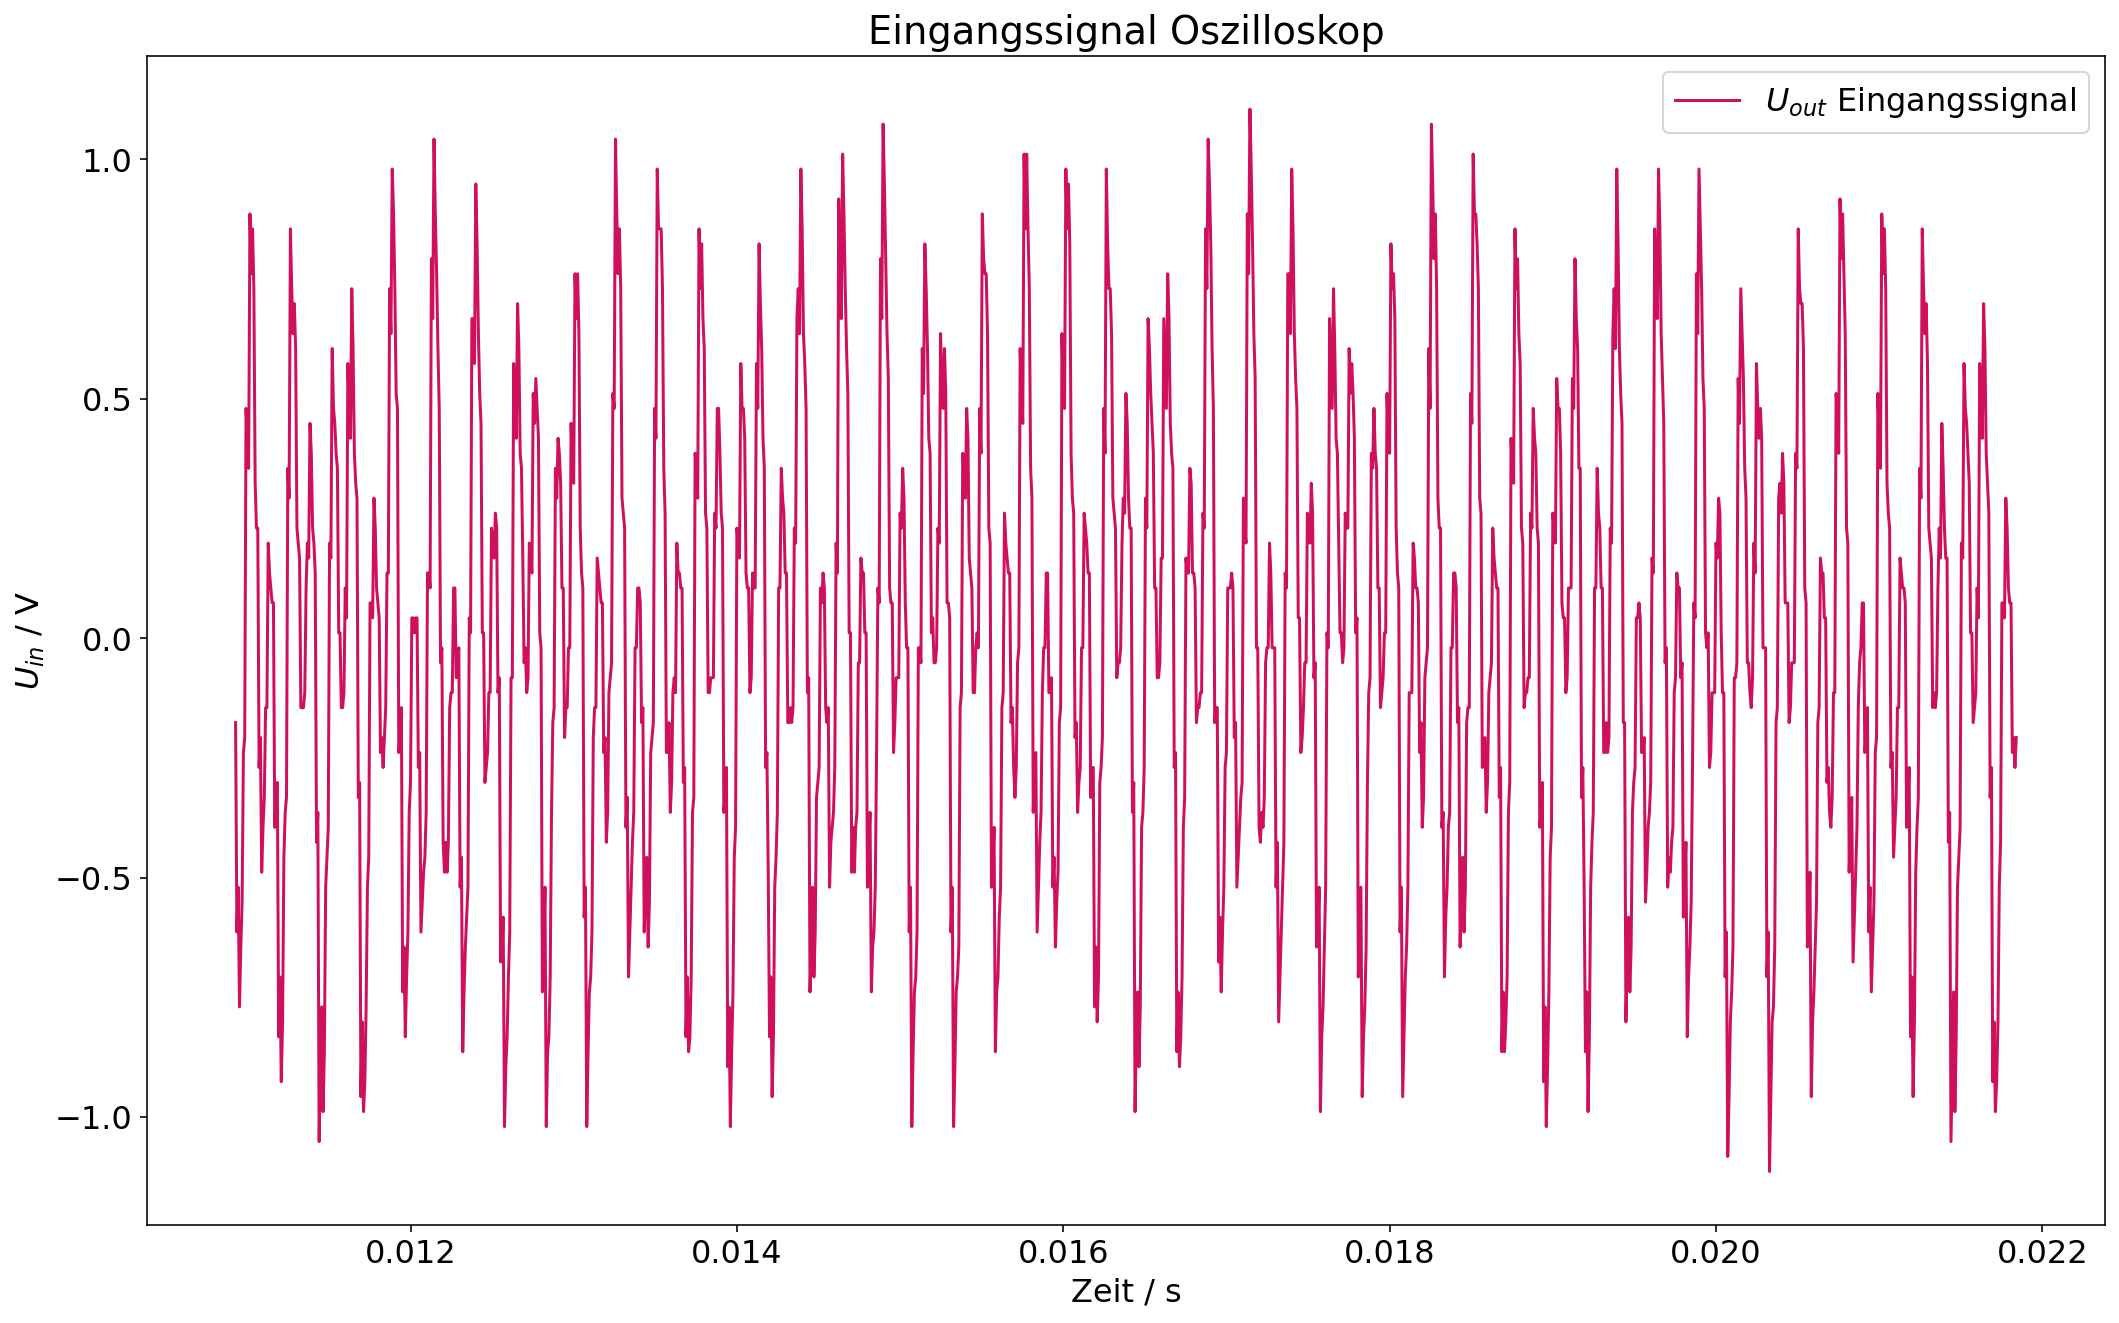

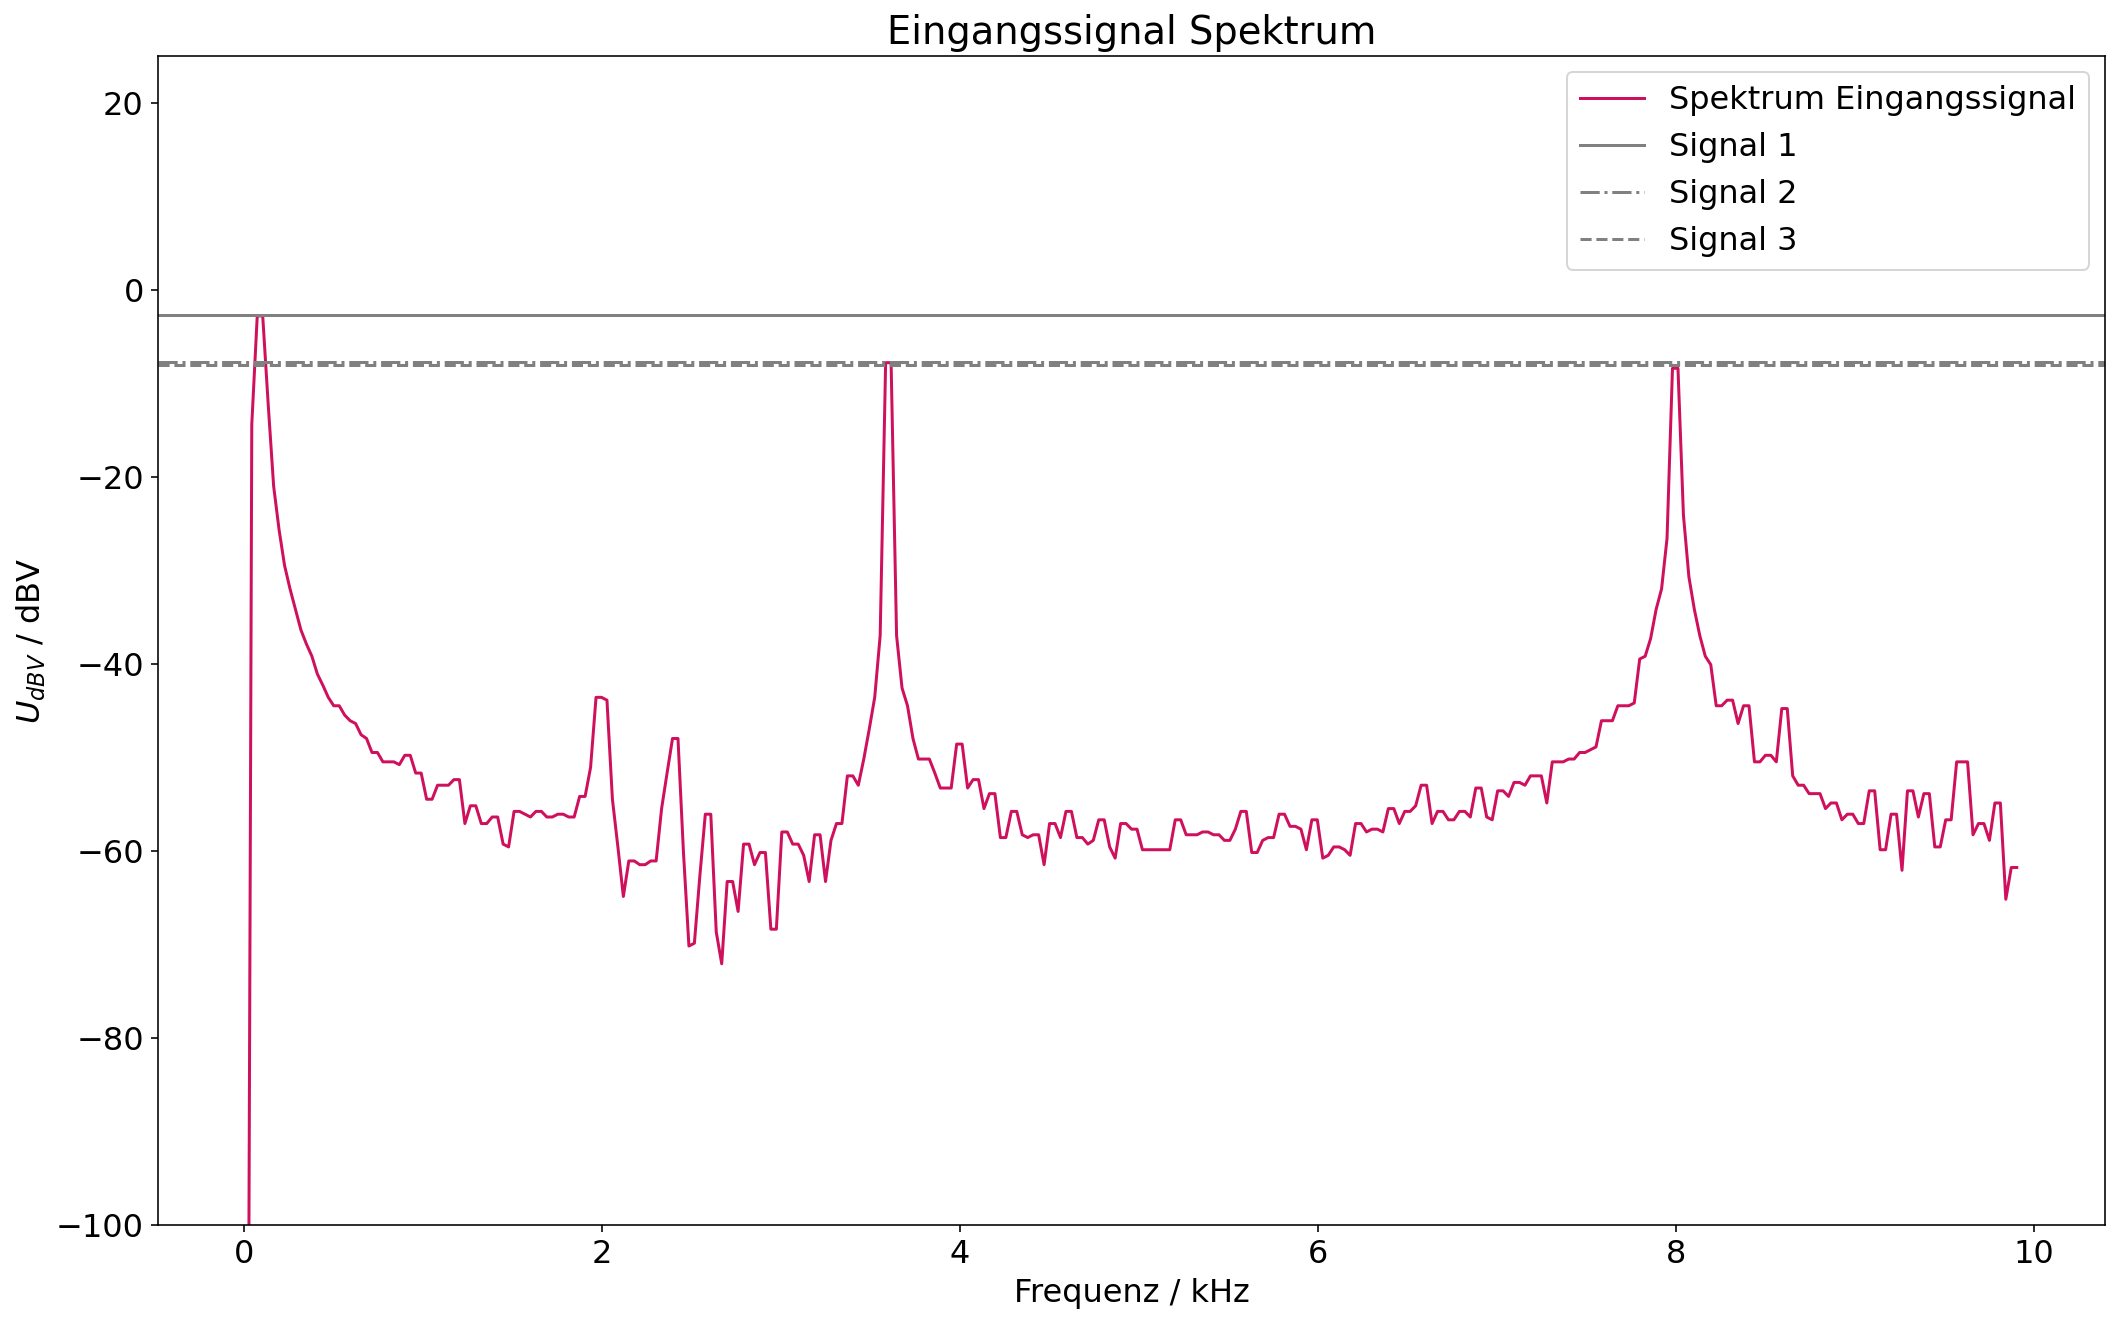

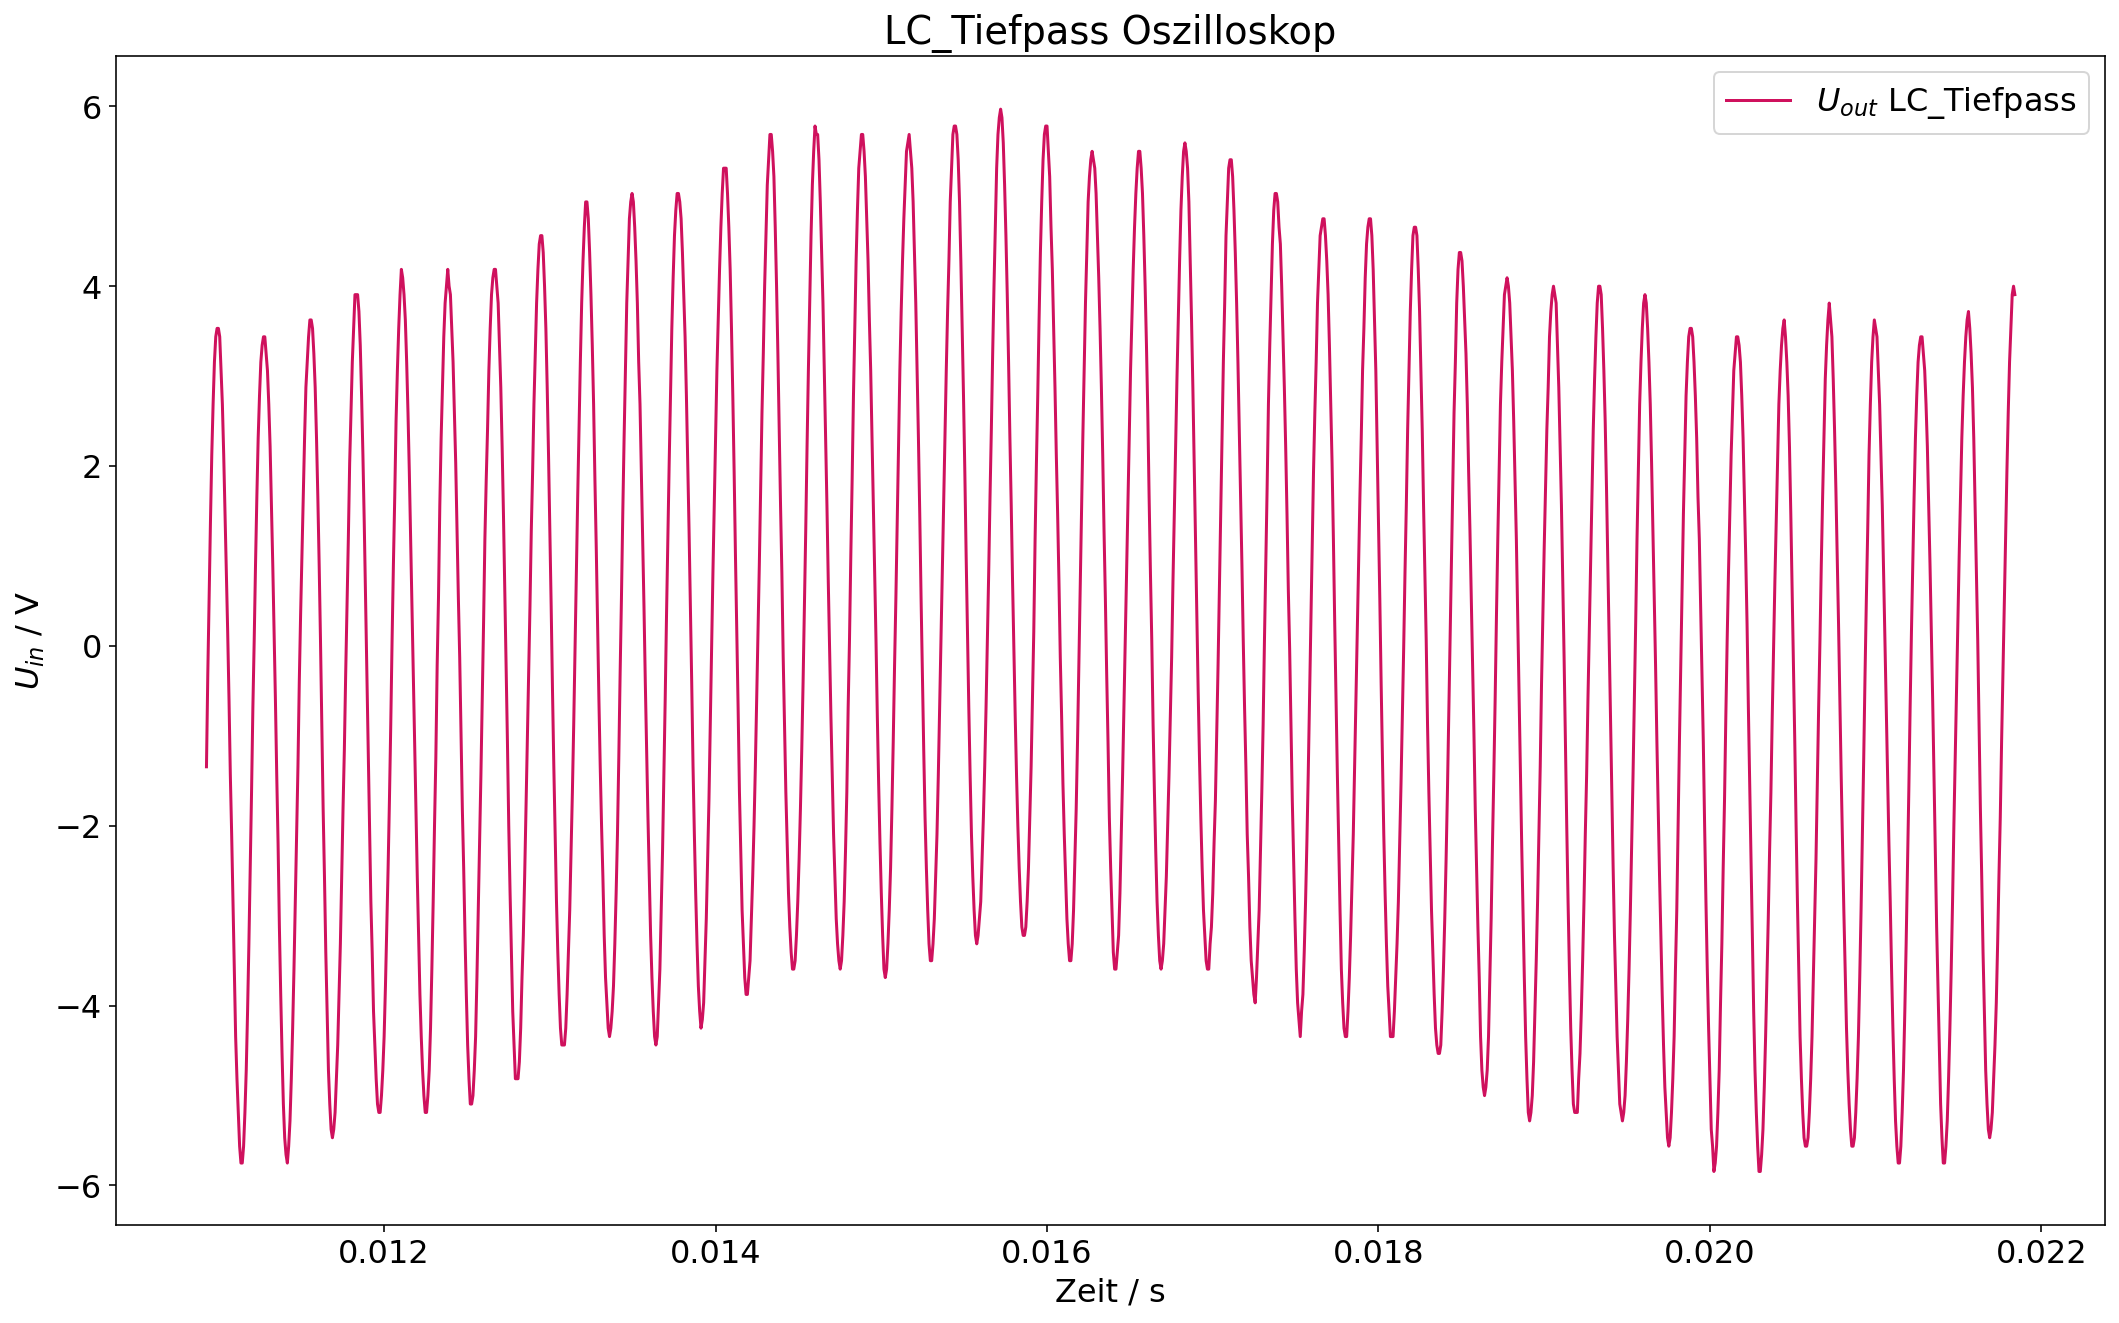

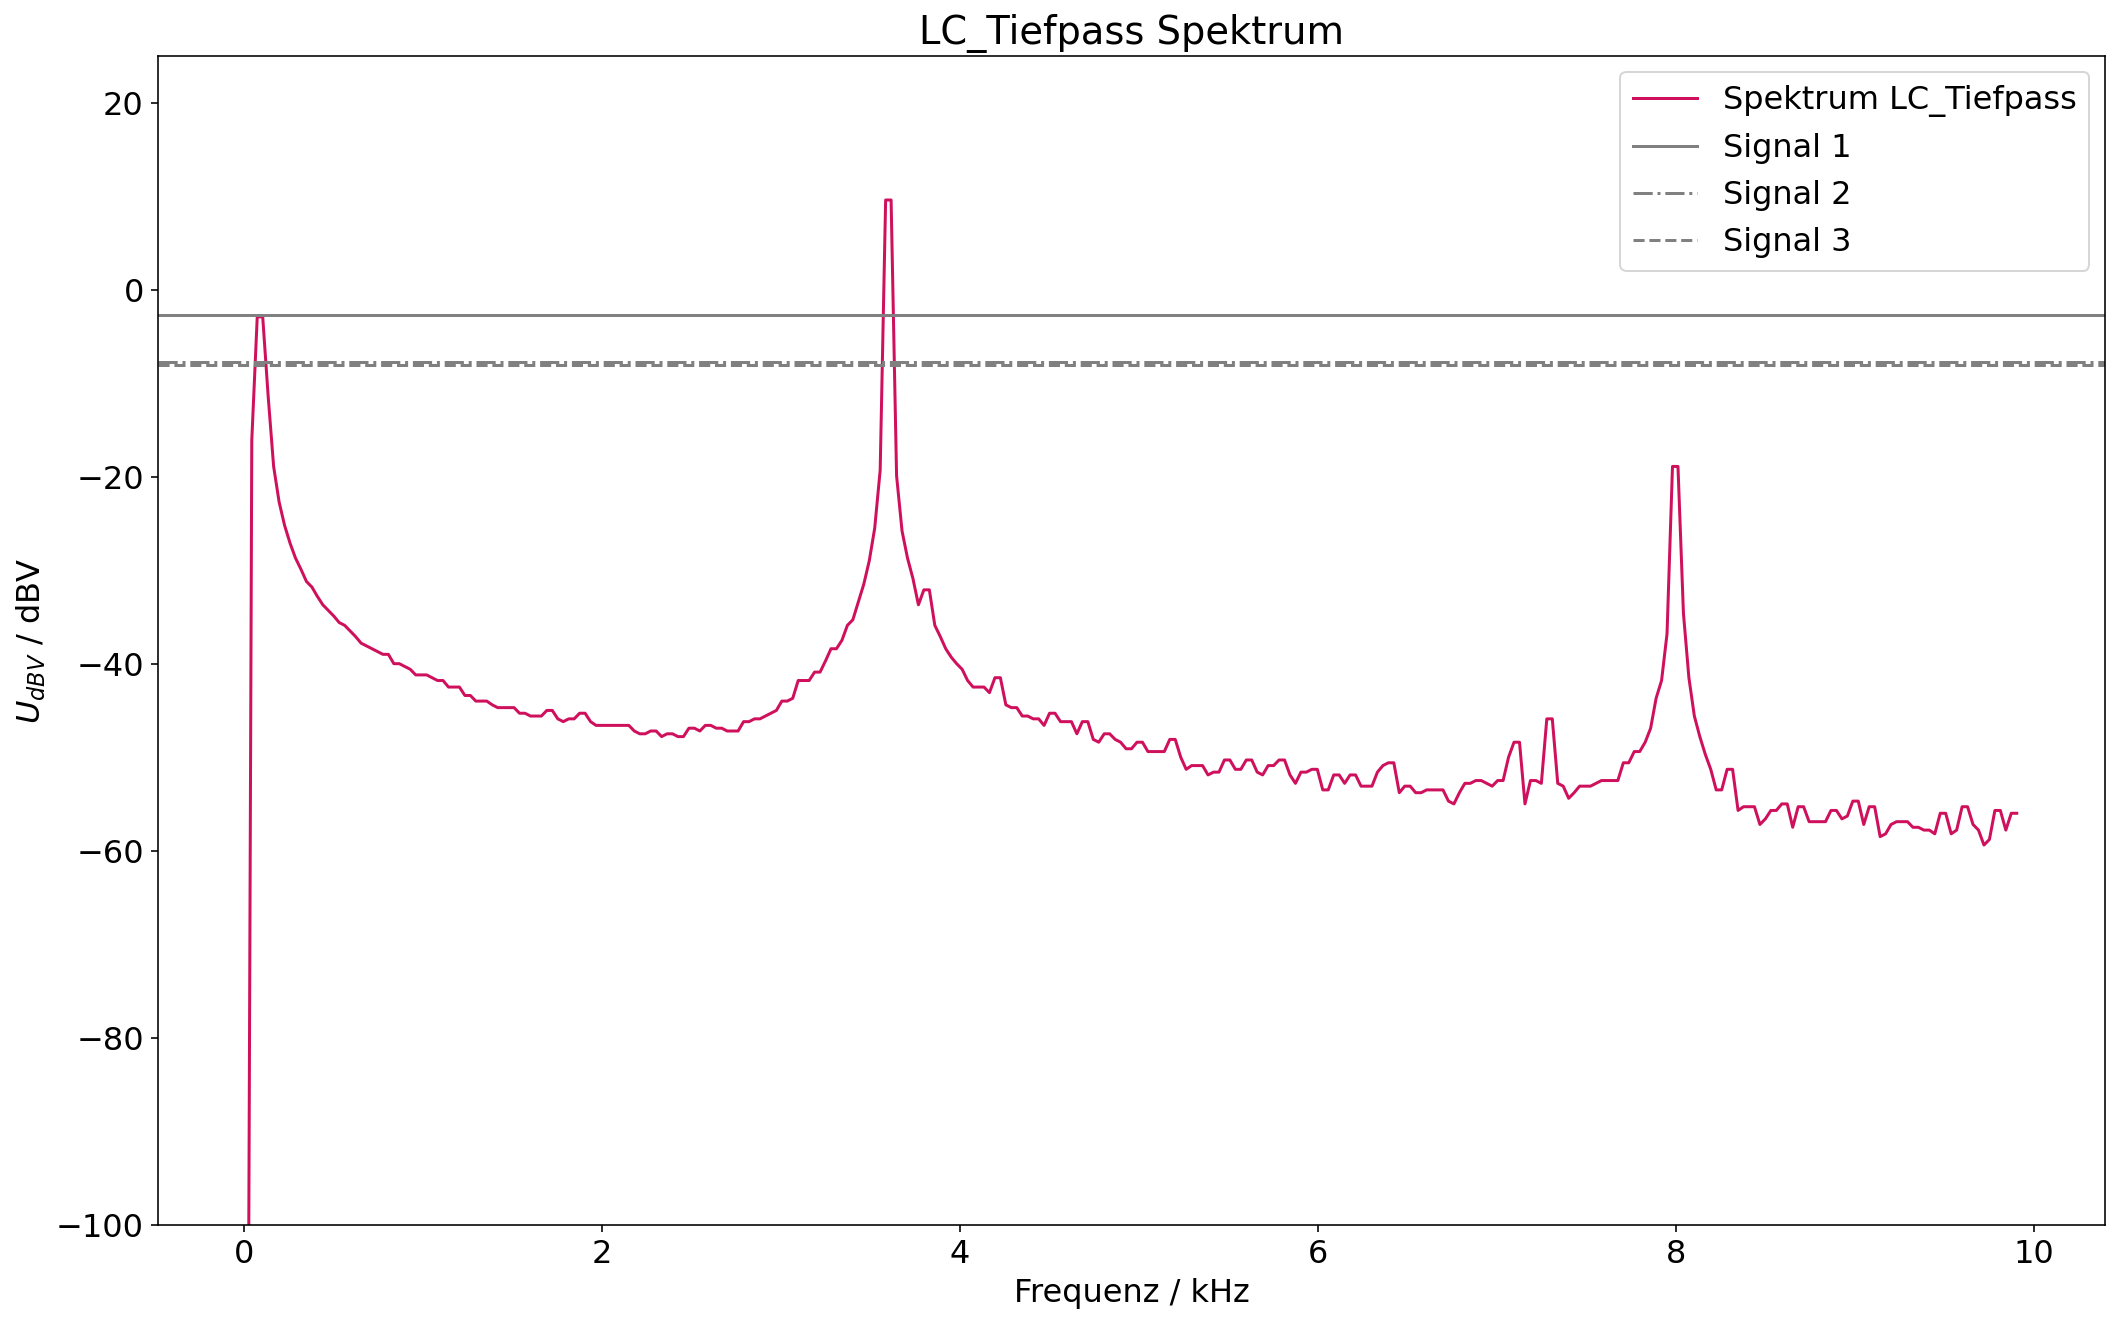

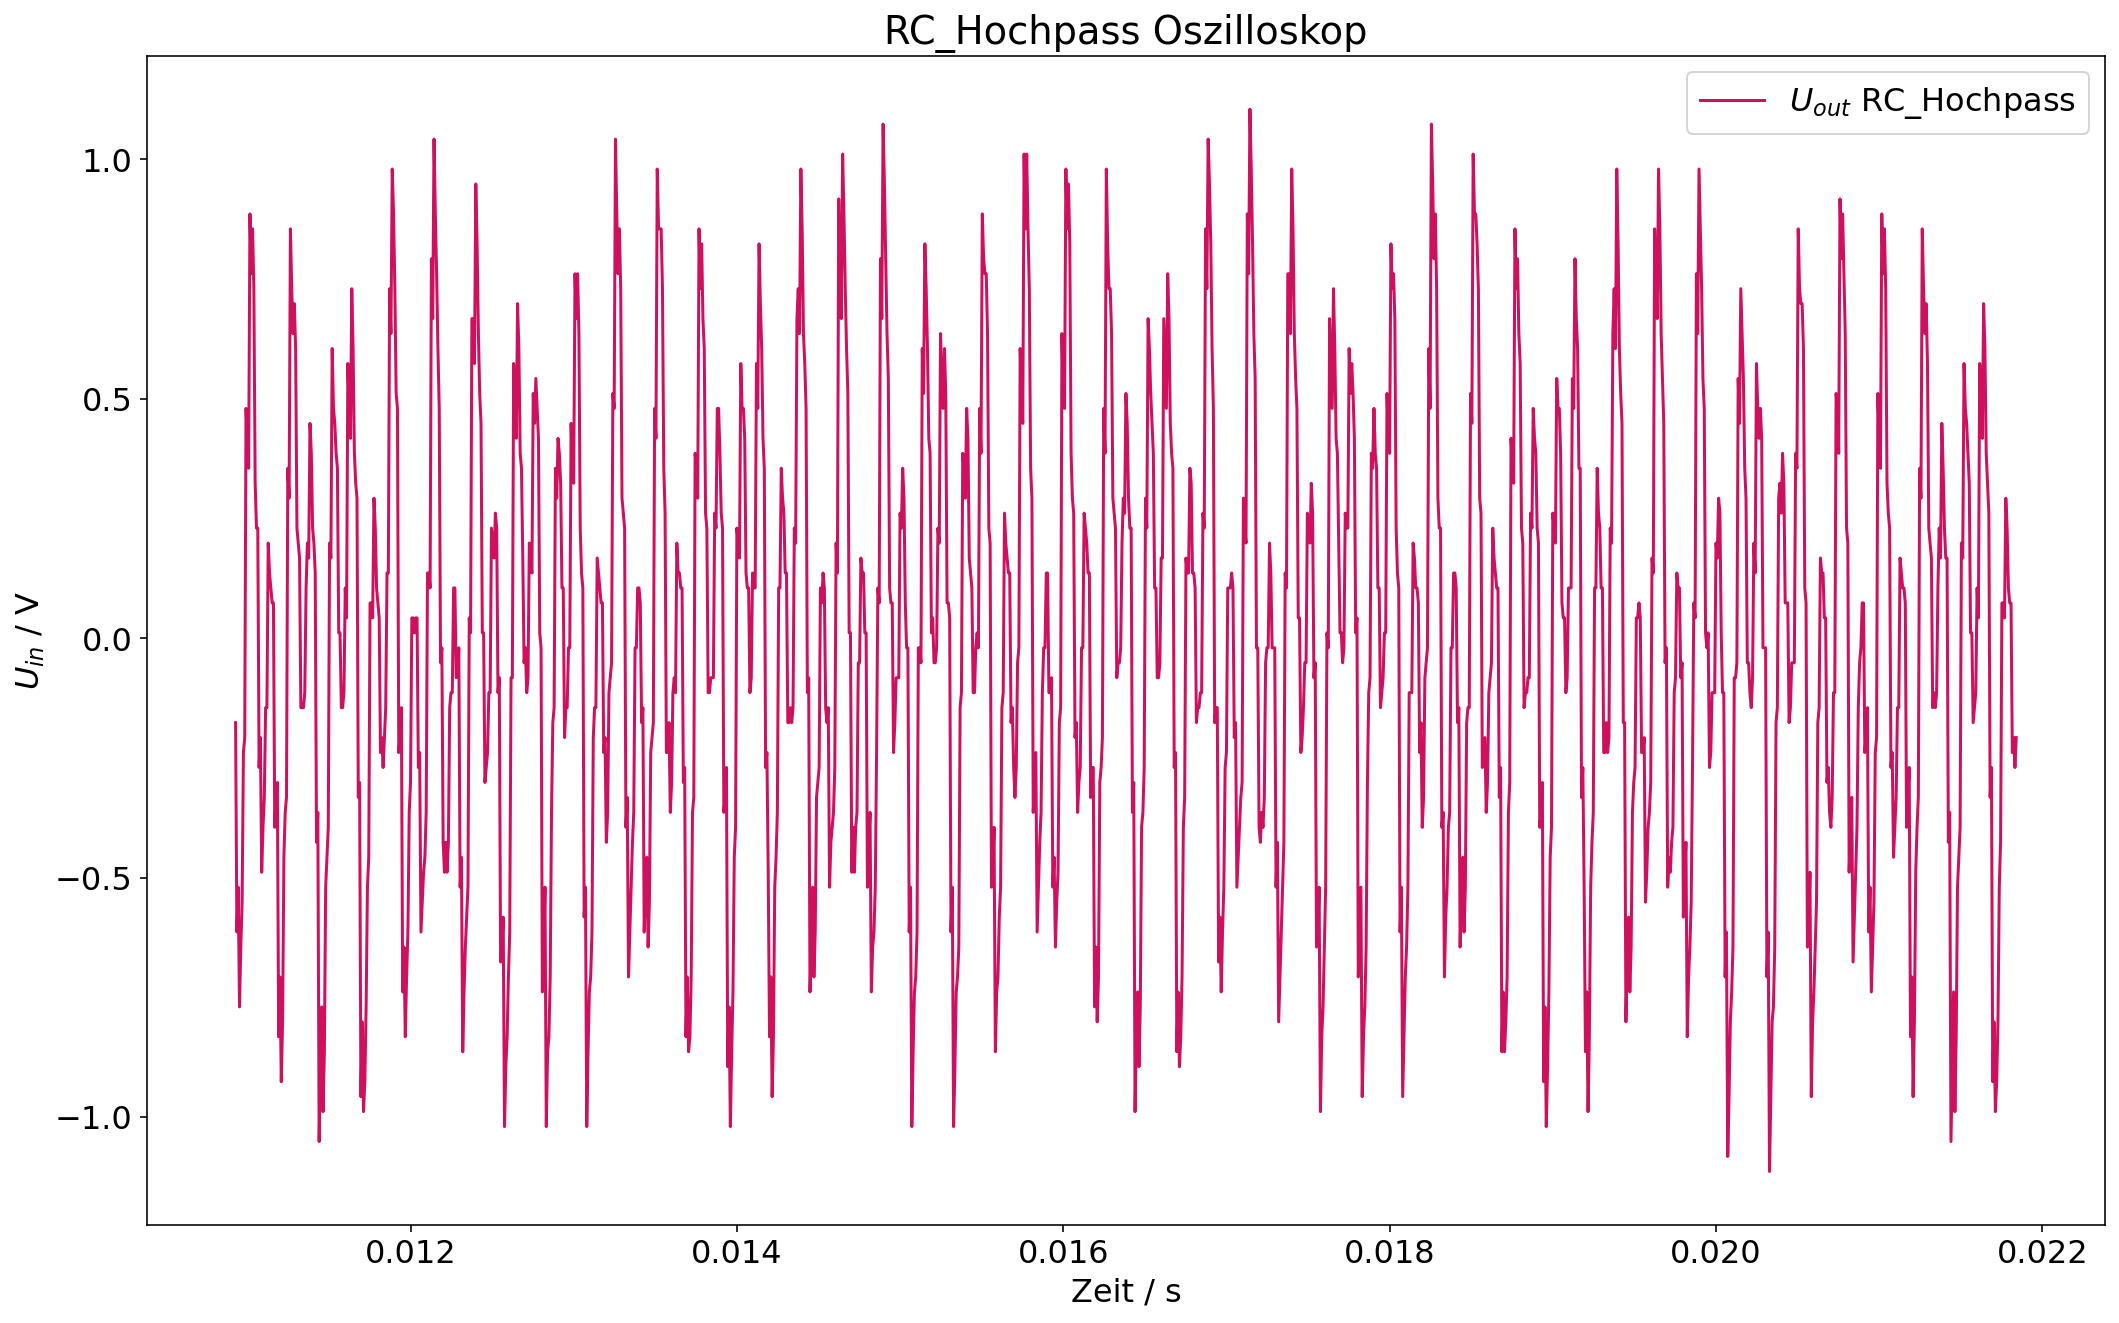

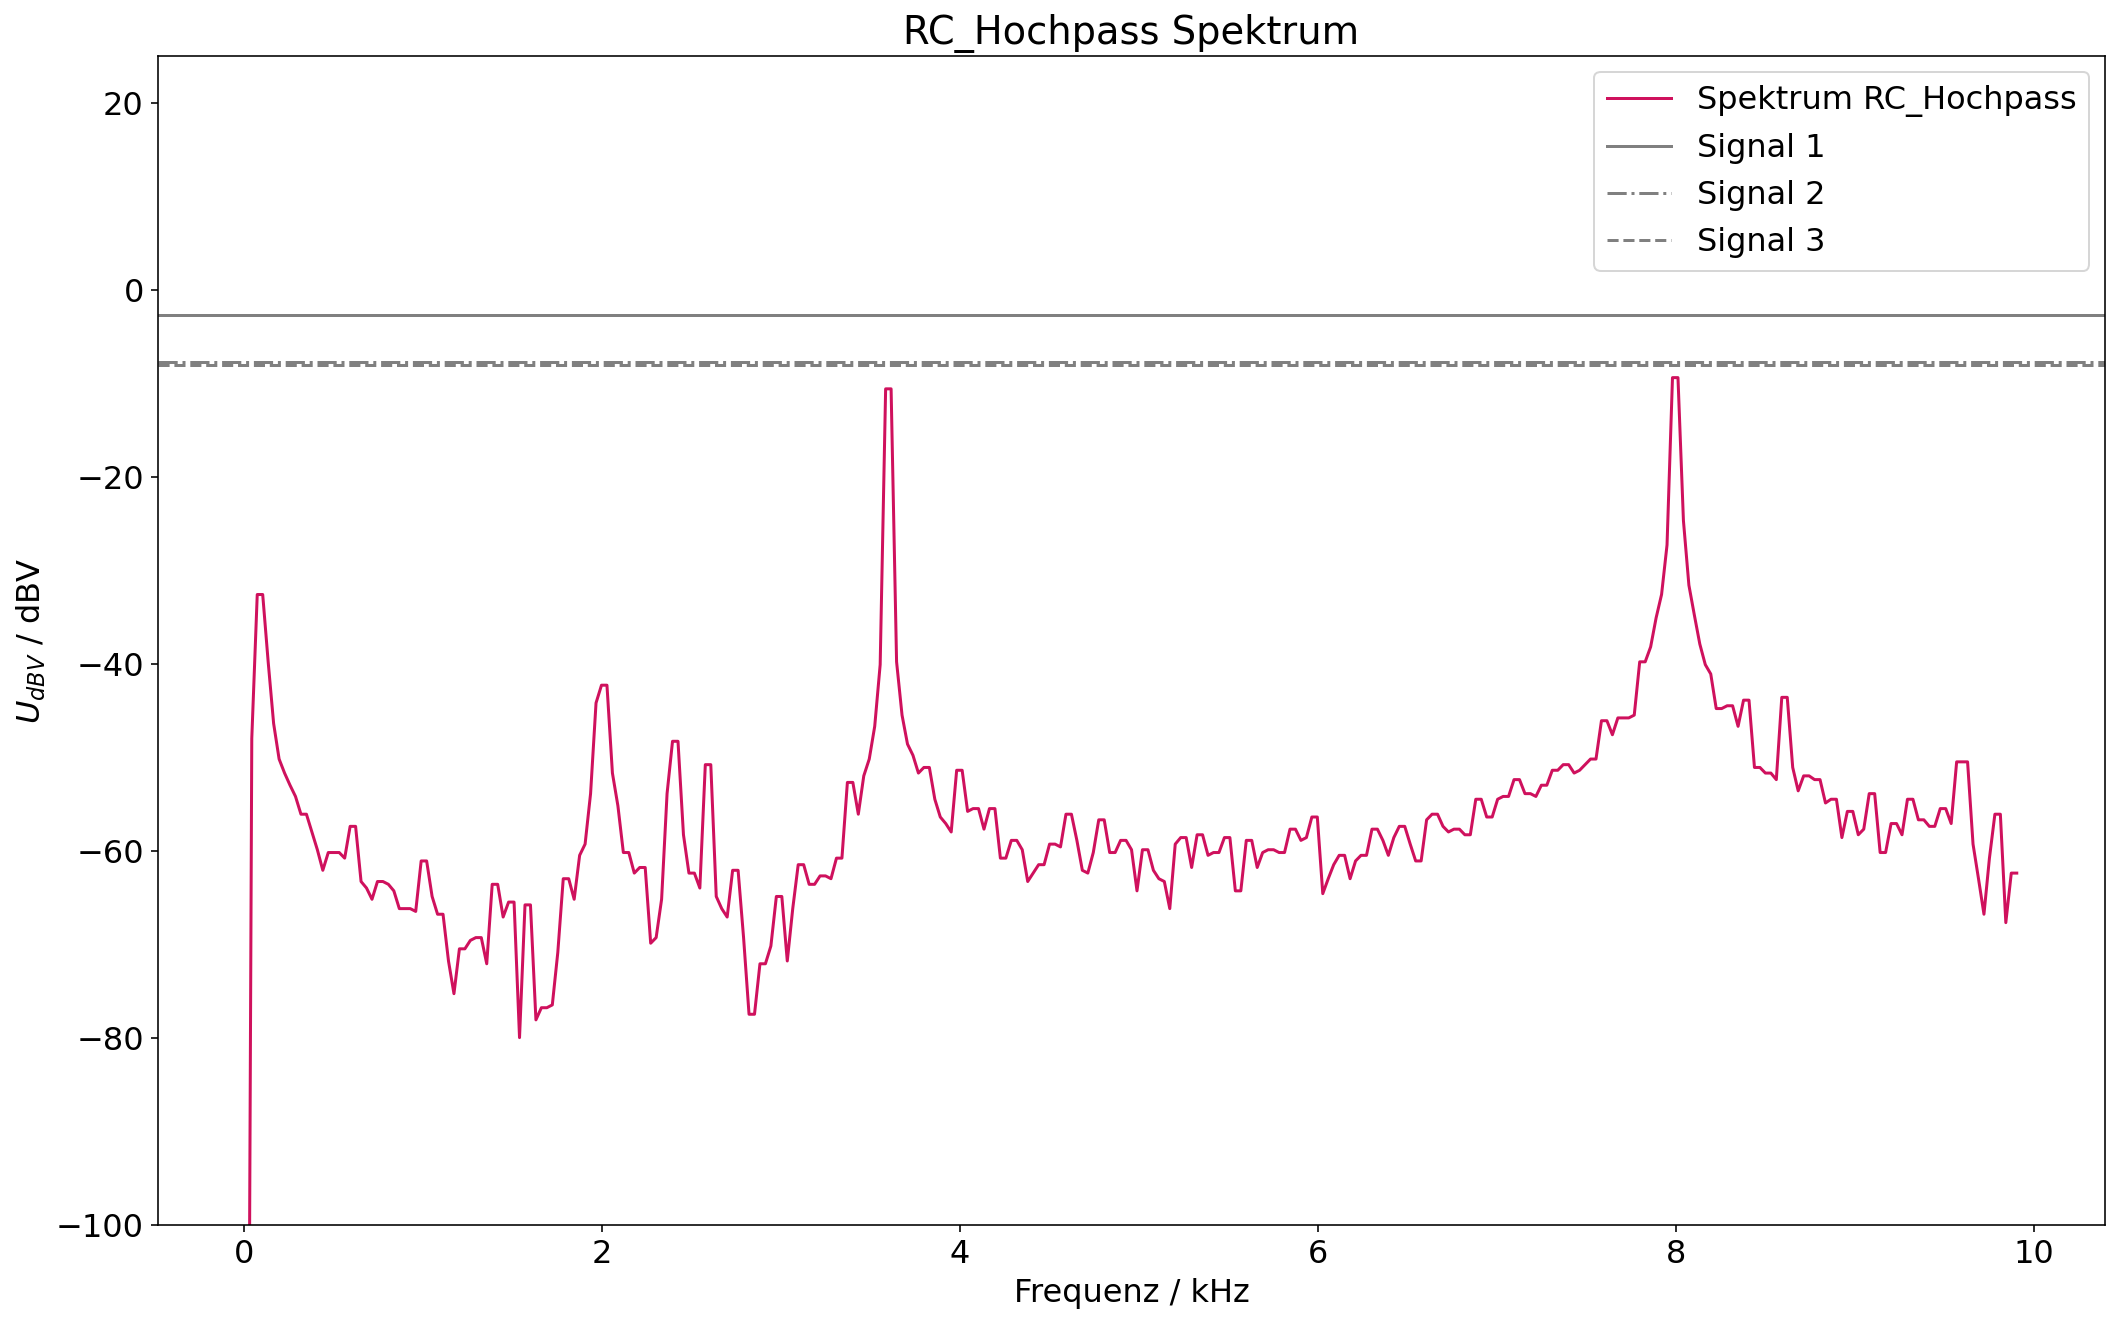

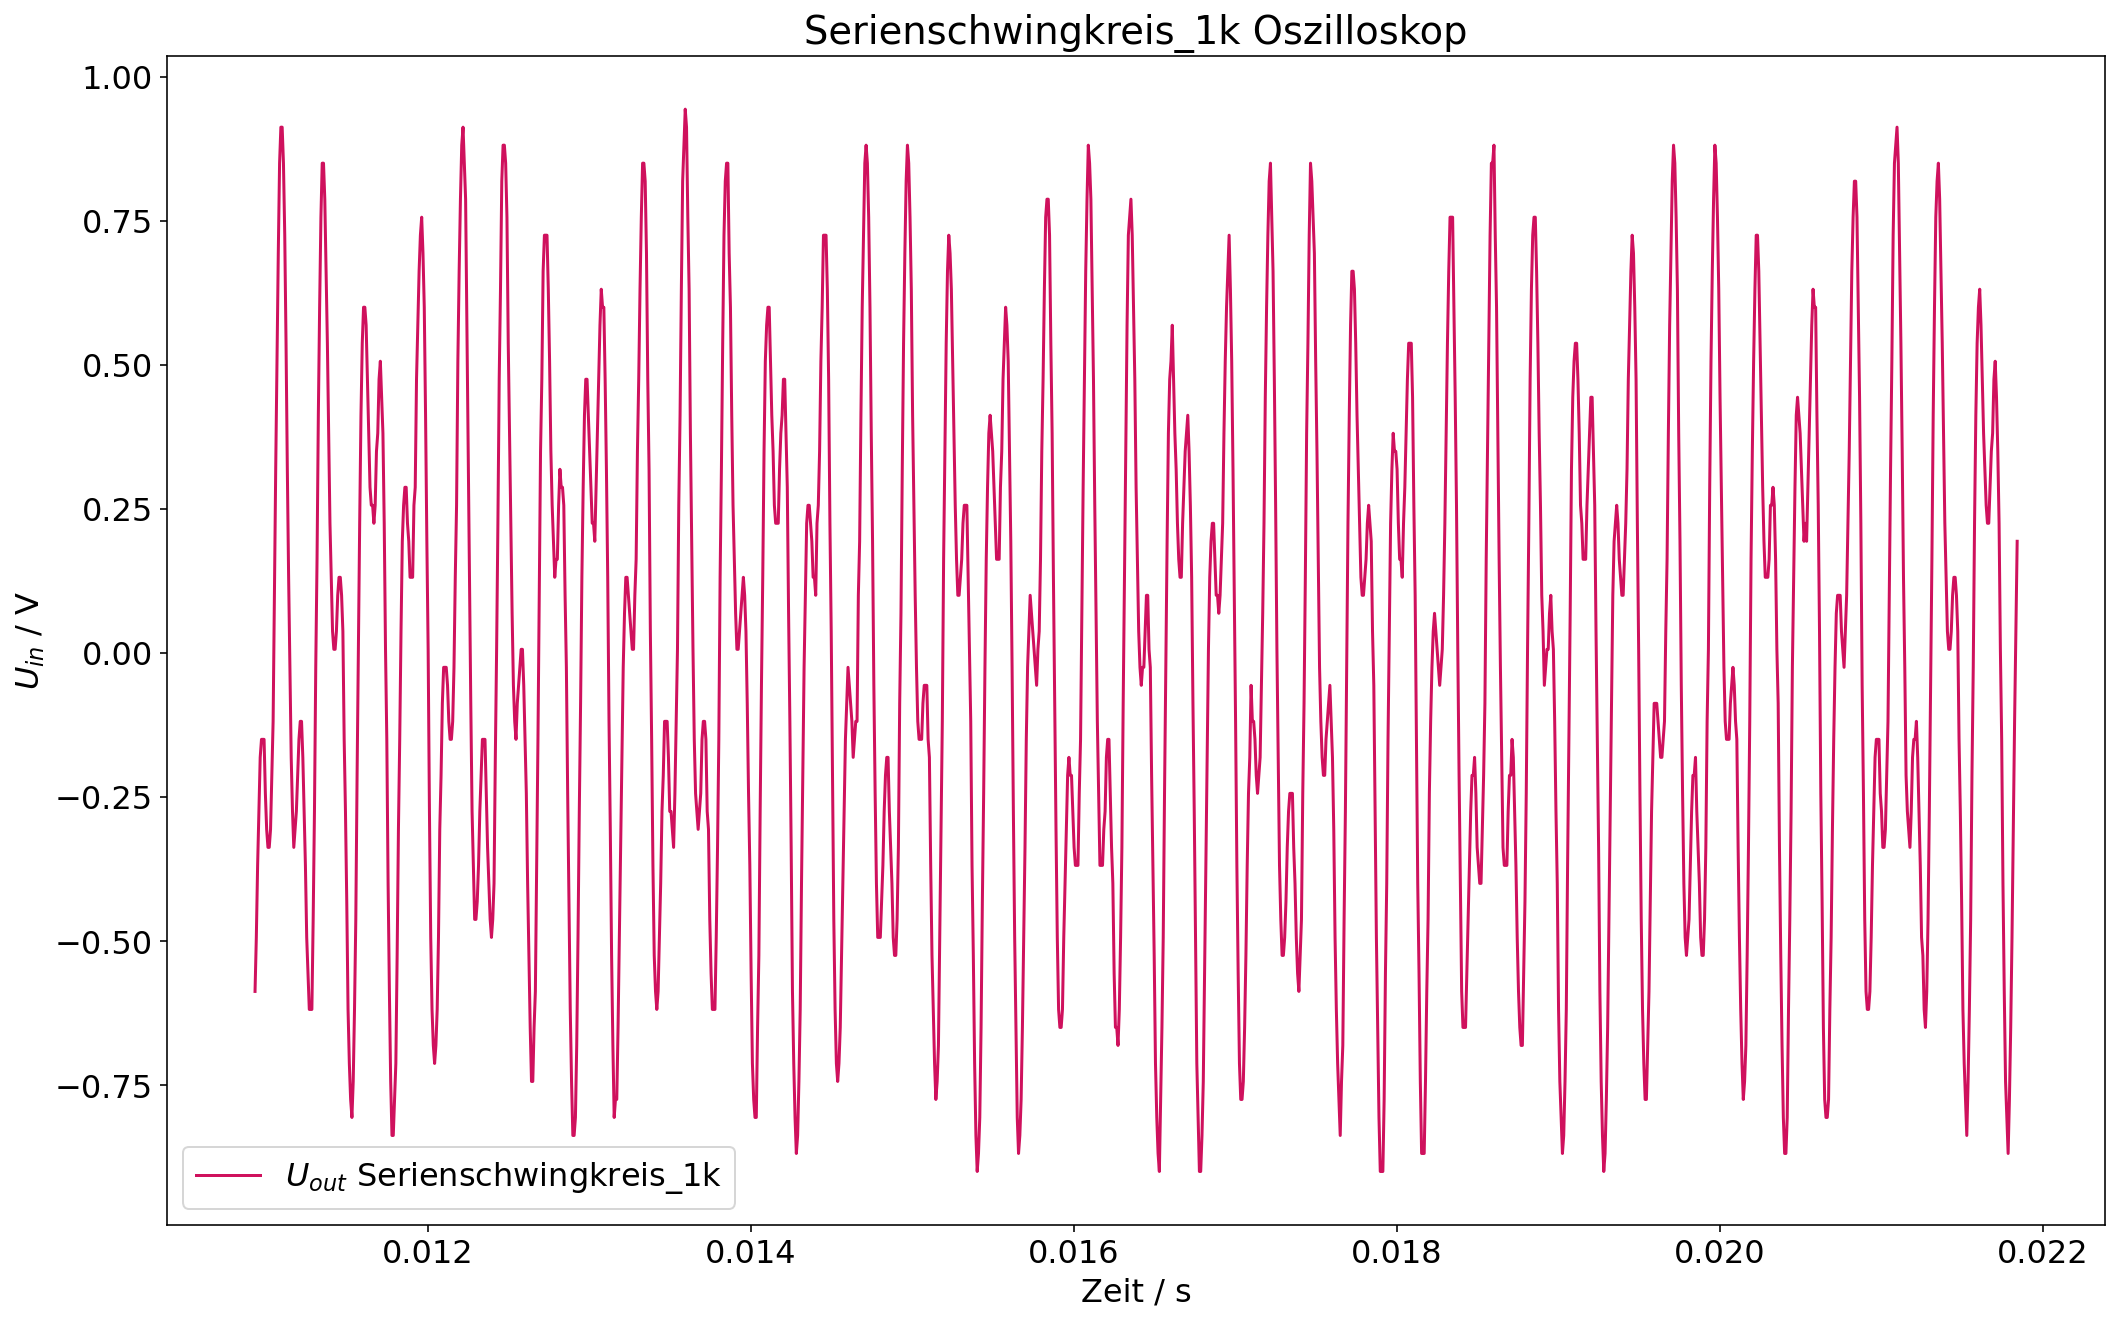

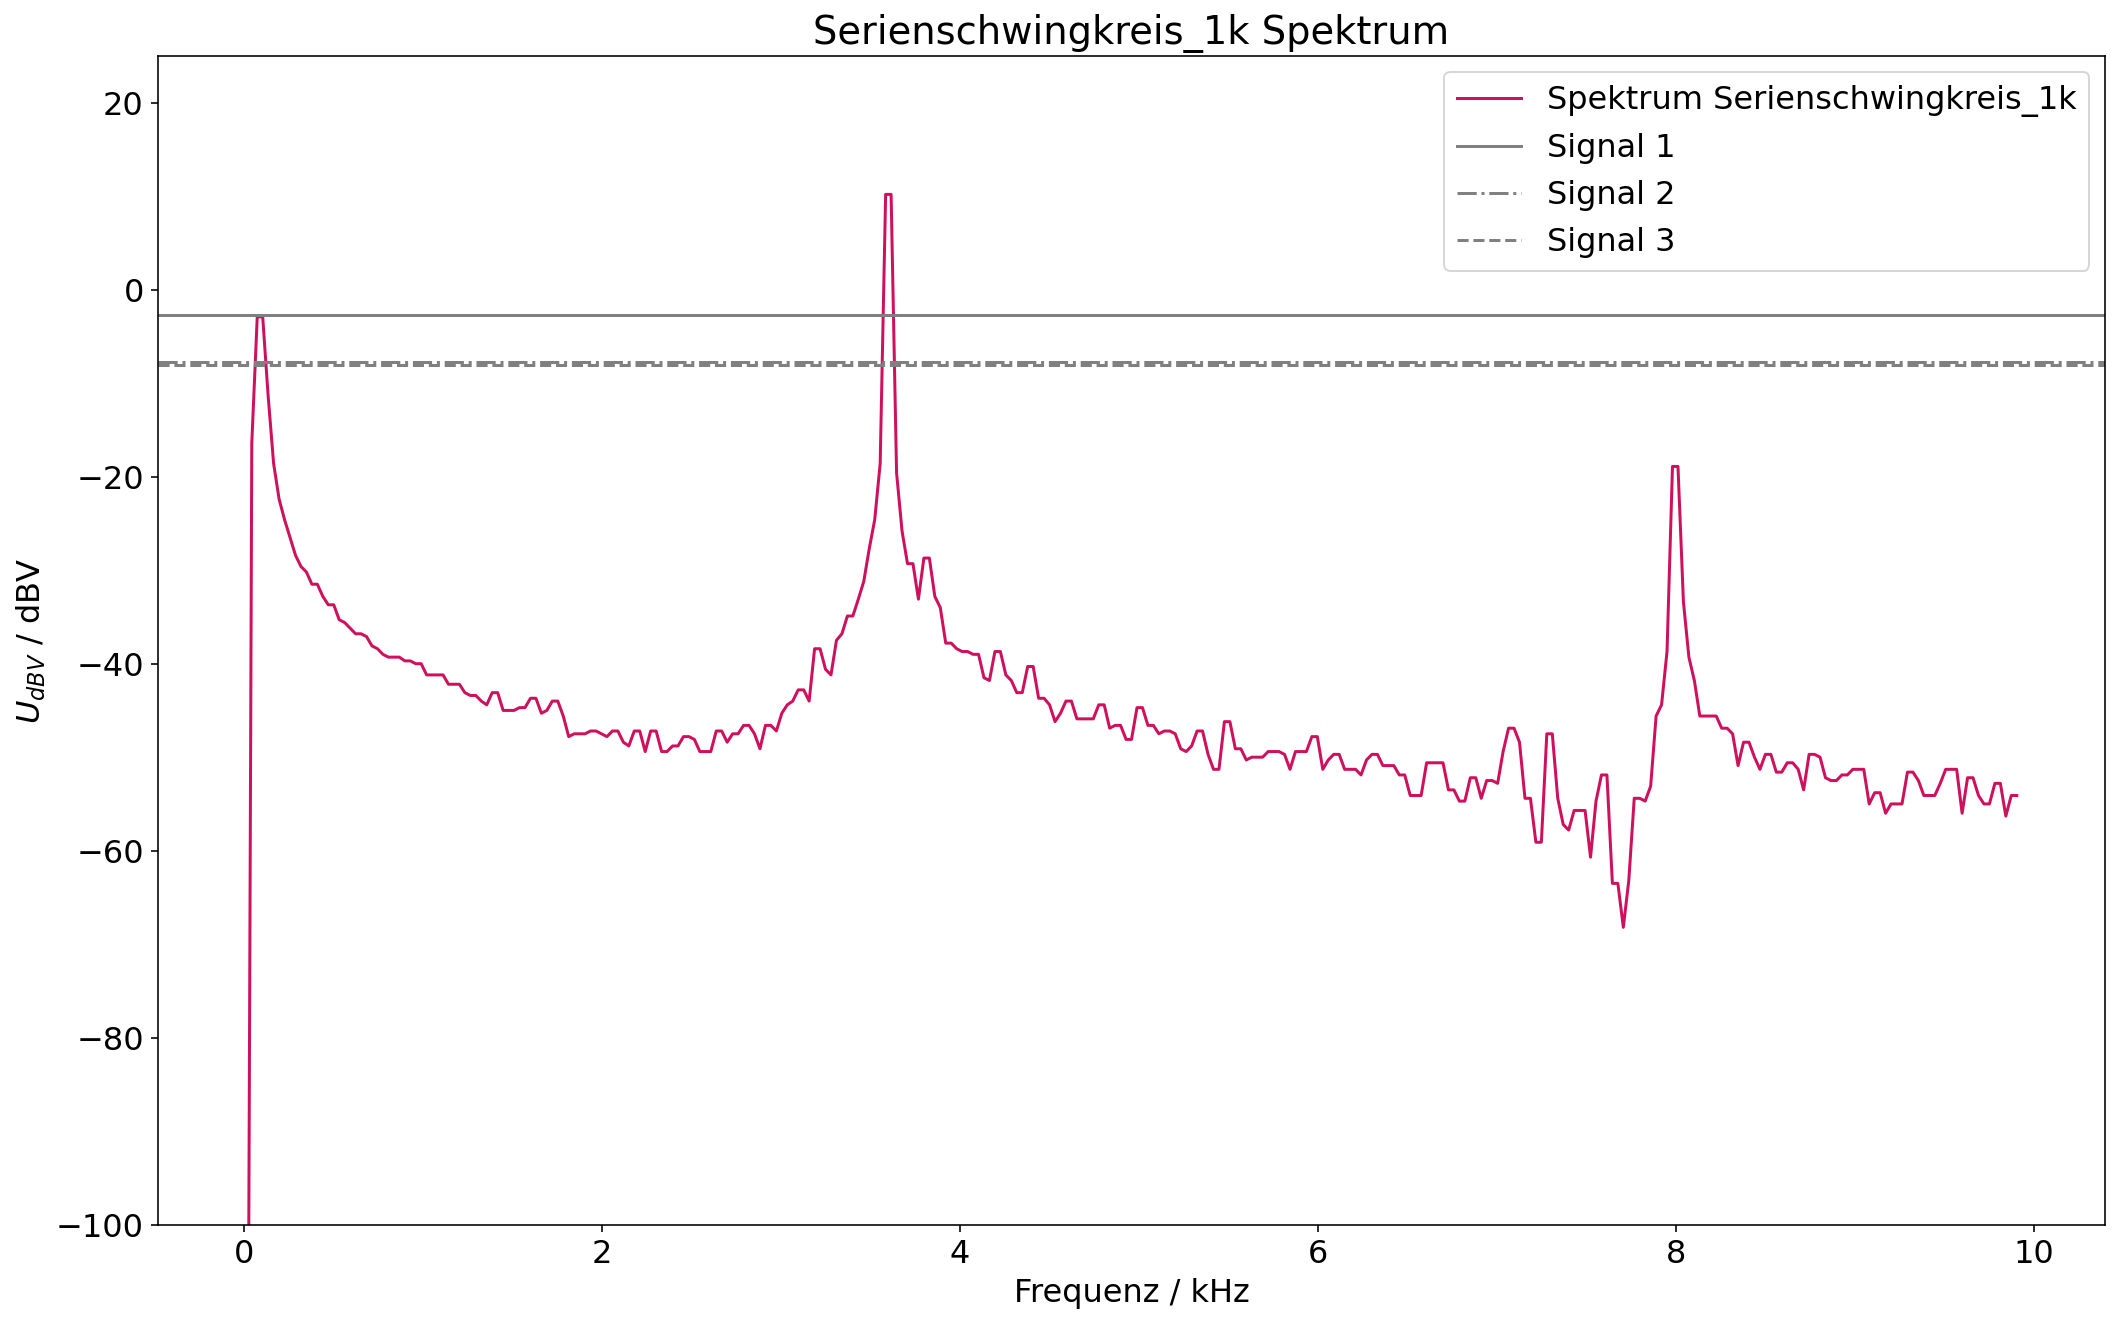

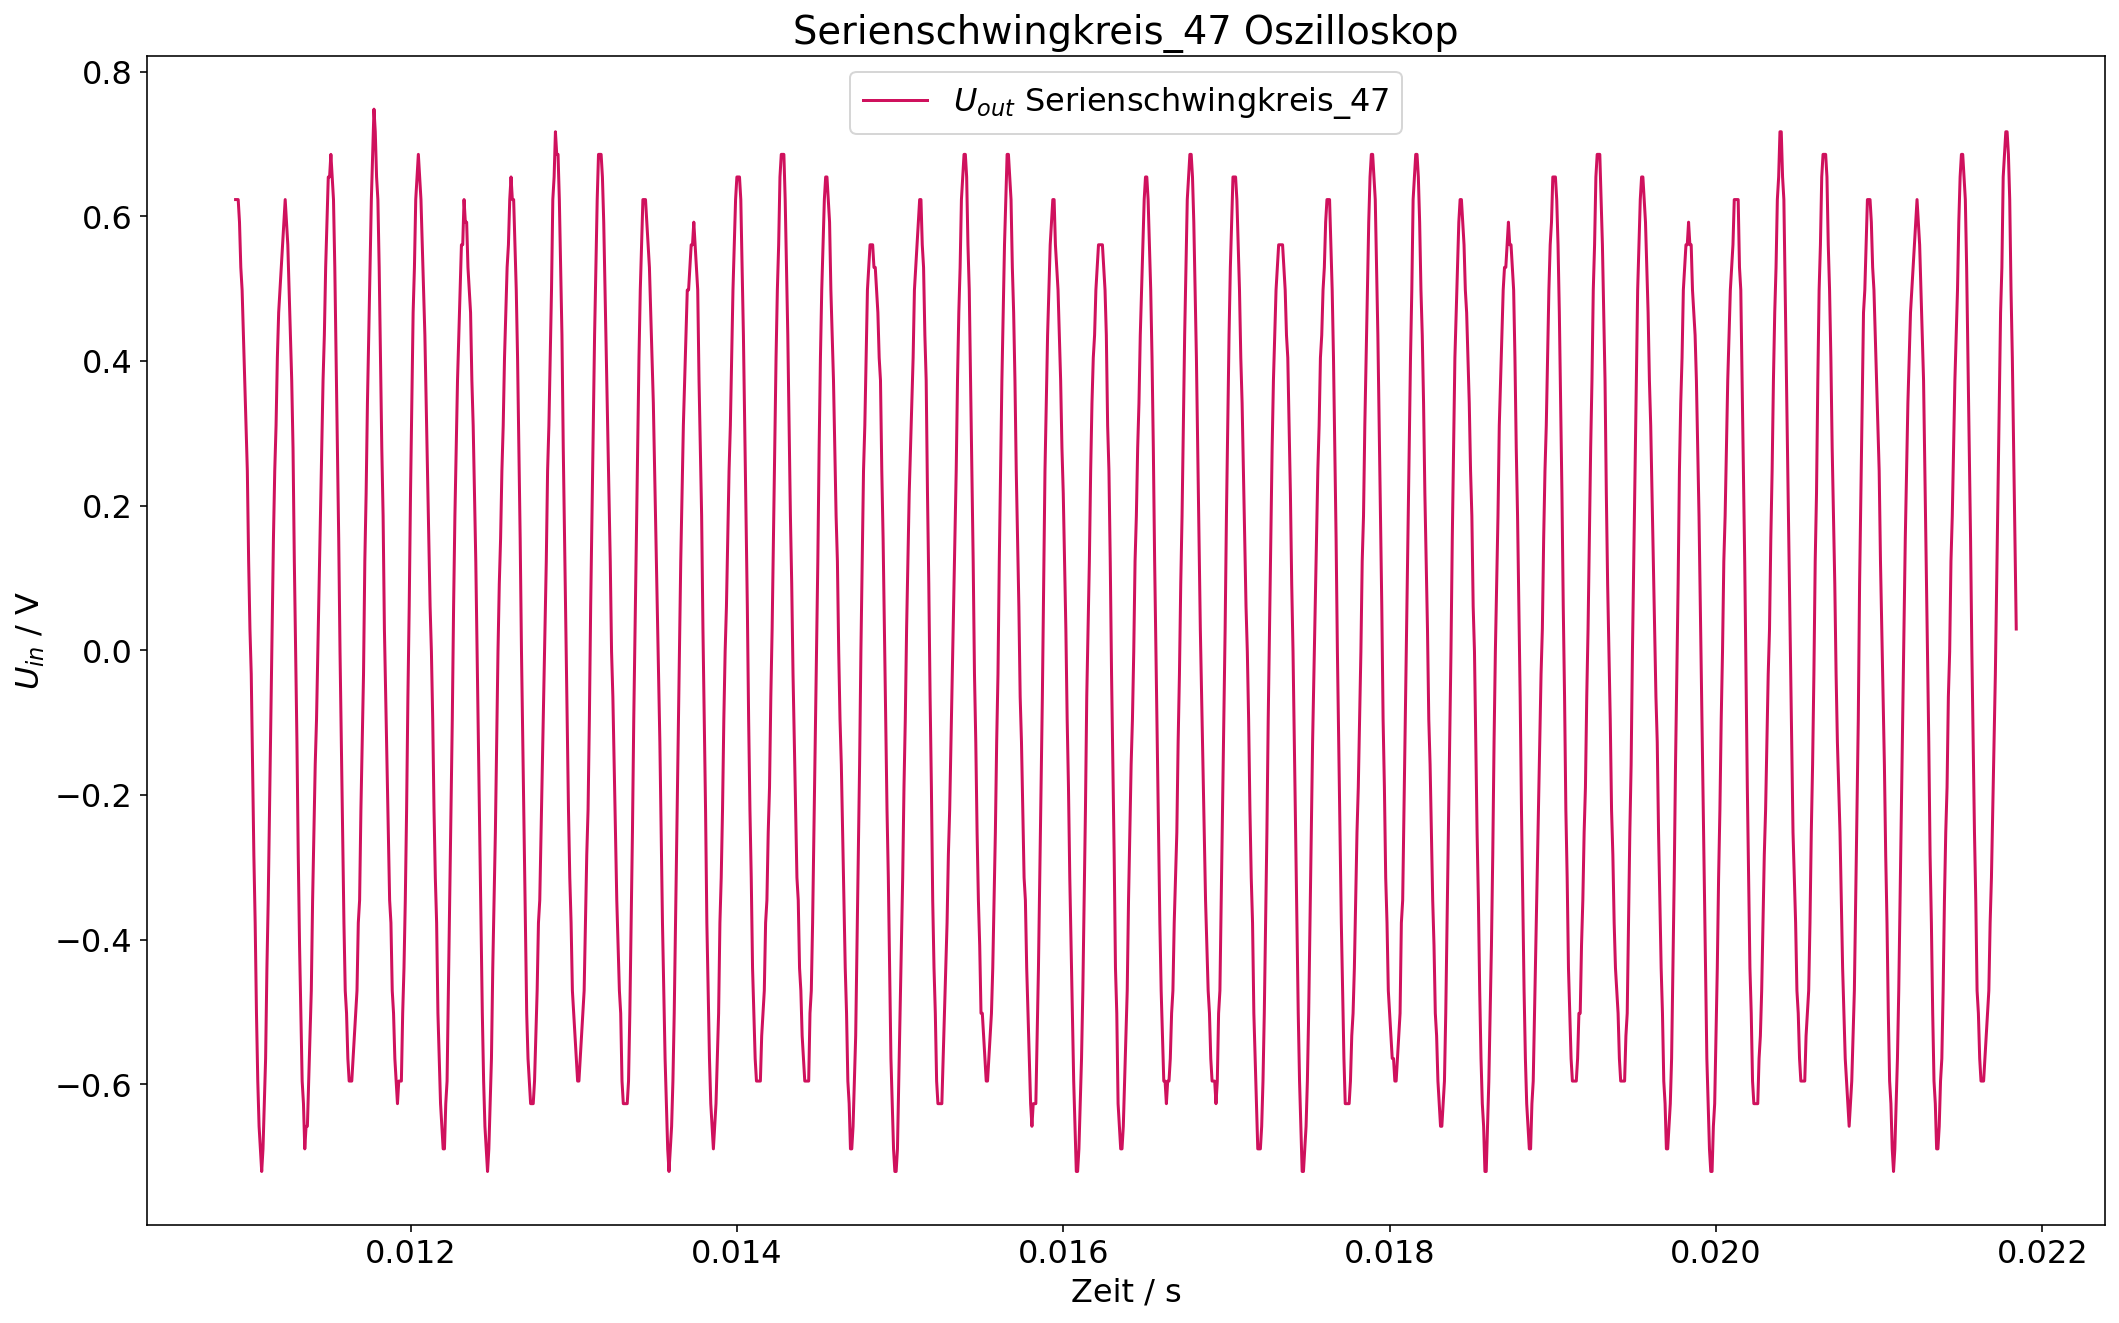

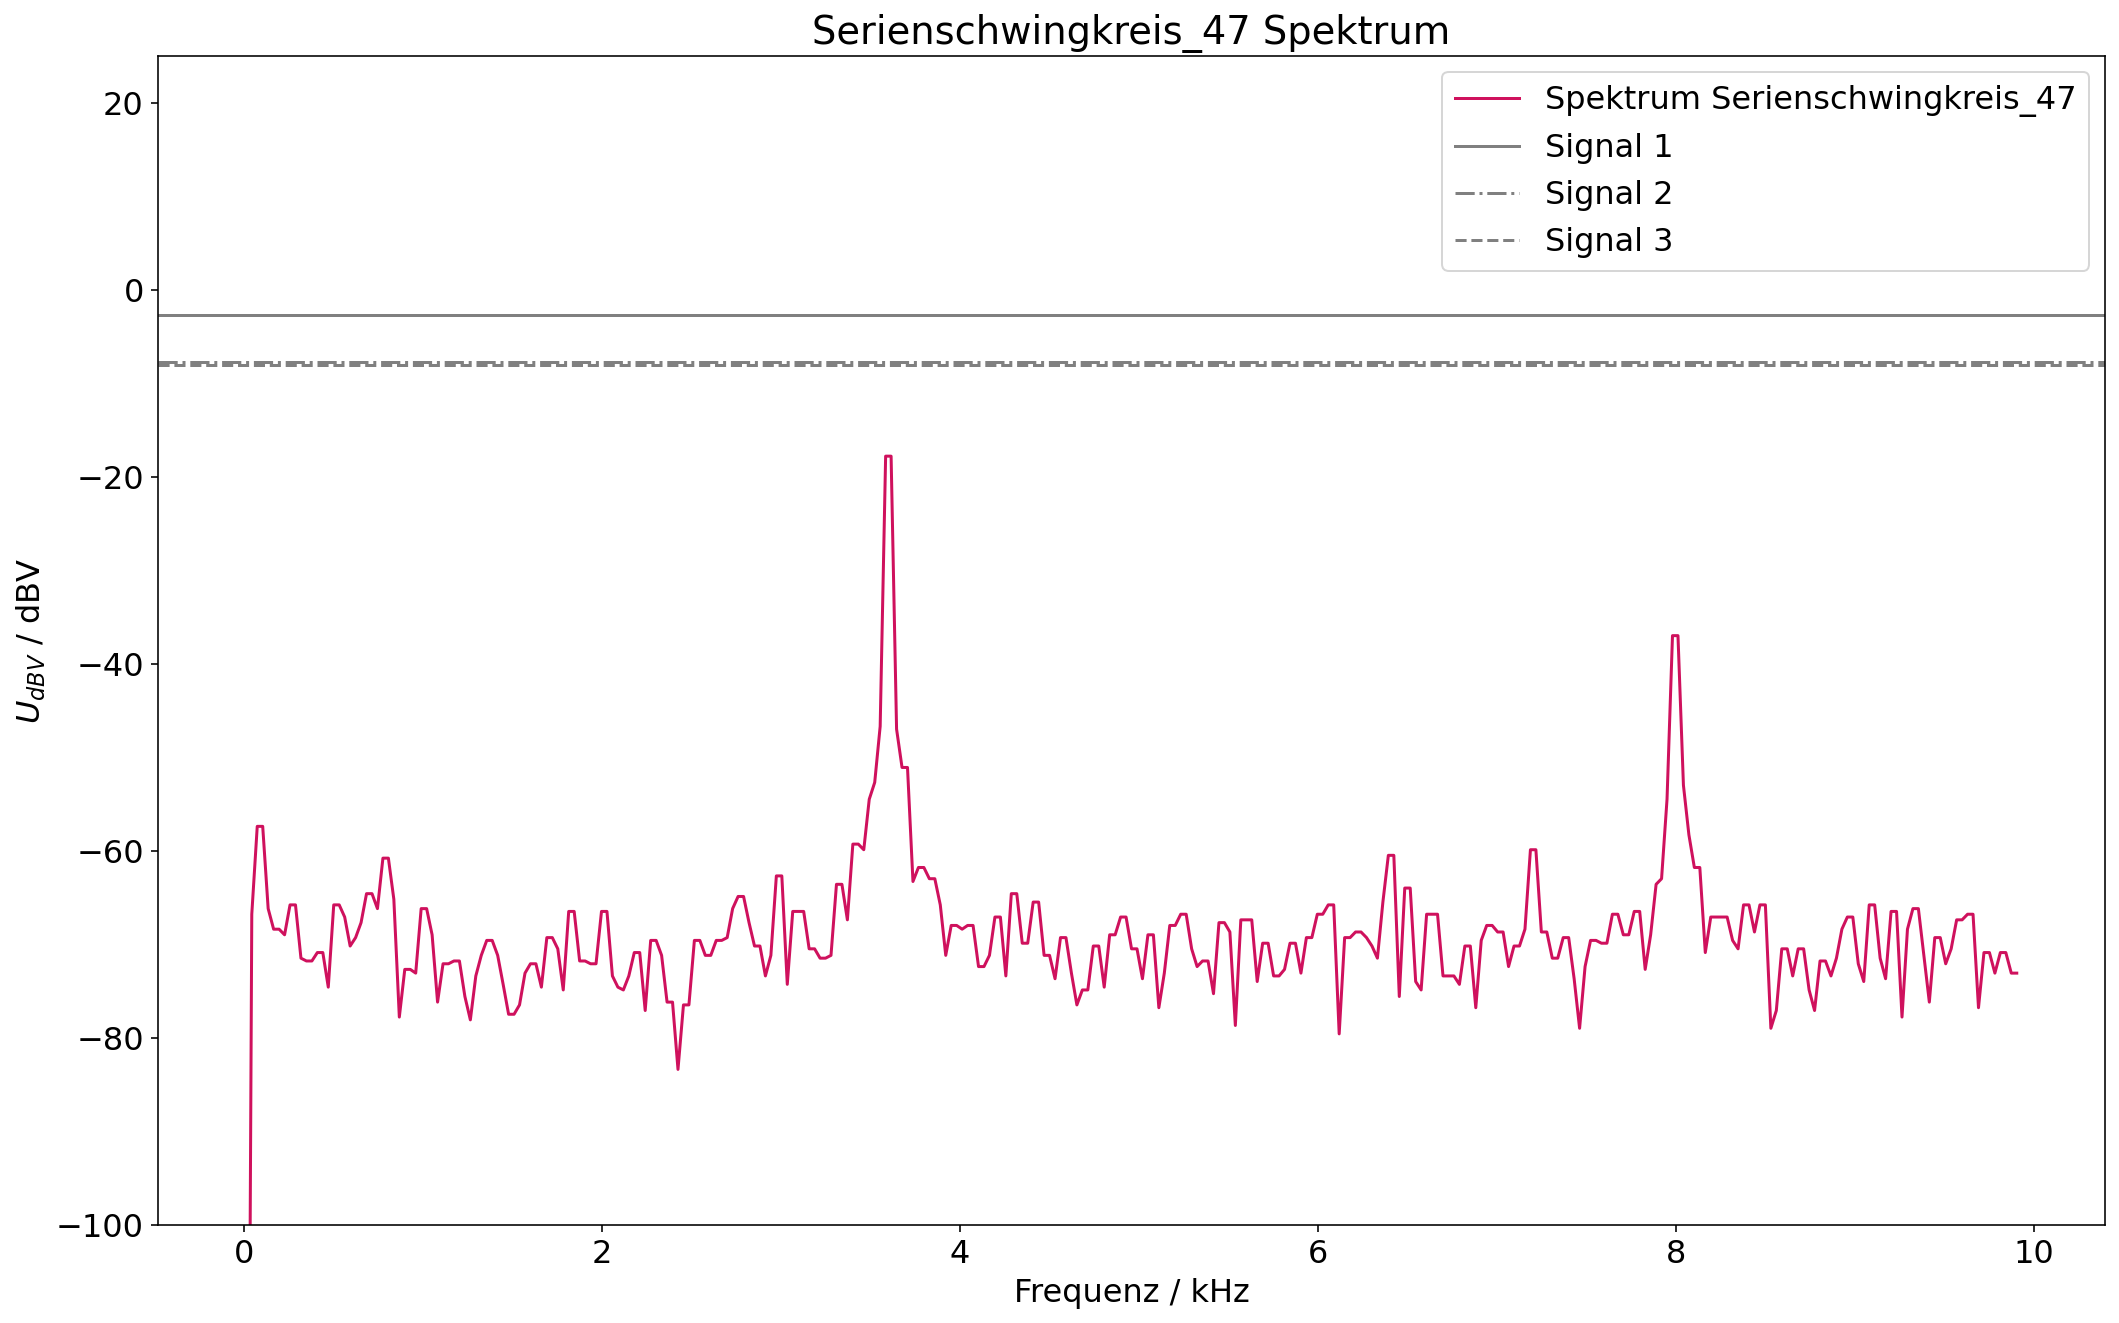

In [6]:
# Einlesen von Daten, CH1 => out, CH2 => in
N, CH1, CH2 = np.loadtxt('data/Messung2_Integrator_Dreieck.txt', skiprows=10, unpack=True)

files =  ['Eingangssignal',
          'LC_Tiefpass',
          'RC_Hochpass',
          'Serienschwingkreis_1k',
          'Serienschwingkreis_47']


filenames = ['eingangssignal',
             'lc_tiefpass',
             'rc_hochpass',
             'bandpass_1k',
             'bandpass_47']

titles =  ['Eingangssignal',
          'LC_Tiefpass',
          'RC_Hochpass',
          'Serienschwingkreis_1k',
          'Serienschwingkreis_47']

files = ['Messung8_' + x for x in files]
filenames = ['messung8_' + x for x in filenames]

DATA_PATH = 'data/'

r_N   = np.array([1, 1, 1, 1, 1])*1e-3 / 125
r_ch1 = np.array([1, 3, 1, 1, 1]) / 32
r_ch2 = np.array([1, 3, 1, 3, 1]) / 32

for i,f in enumerate(files):
    frequenz, U_dBV = np.loadtxt(DATA_PATH+f+'_Spektrum.txt', usecols=(1,2), skiprows=1, unpack=True)
    N, CH1, CH2 = np.loadtxt(DATA_PATH+f+'_Oszi.txt', skiprows=11, unpack=True)

    t0     = r_N[i]   * N   # s;
    U_out0 = r_ch1[i] * CH1 # V;
    U_in0  = r_ch2[i] * CH2 # V;
    
    l = len(t0)
    t0 = t0[l//3:2*l//3]
    U_out0 = U_out0[l//3:2*l//3]
    U_in0 = U_in0[l//3:2*l//3]
    
    U_out0 = U_out0 - np.mean(U_out0)
    U_in0 = U_in0 - np.mean(U_in0)

    ### Oszi 
    if mpl.get_backend() == 'pgf':
        plt.clf()
        plt.figure(figsize=(default_width, default_width*default_ratio))
    
    plt.plot(t0, U_out0, label=fr'$U_{{out}}$ {titles[i]}')
    plt.xlabel('Zeit / s')
    plt.ylabel(r'$U_{in}$ / V')
    plt.legend()
    
    # save and show
    filename = filenames[i]+'_oszi'
    if mpl.get_backend() == 'pgf':
        plt.savefig(FIGURE_PATH+filename+'.pgf', format='pgf')
        plt.savefig(FIGURE_PATH+filename+'.pdf', format='pdf')
        plt.clf()
        
    plt.title(titles[i] + ' Oszilloskop')
    plt.show()
    
    ### Spektrum
    if mpl.get_backend() == 'pgf':
        plt.clf()
        plt.figure(figsize=(default_width, default_width*default_ratio))
    
    plt.plot(frequenz, U_dBV, label=f'Spektrum {titles[i]}')
    plt.axhline(y=-2.75, linestyle='-',  color='gray', label='Signal 1')
    plt.axhline(y=-7.75, linestyle='-.', color='gray', label='Signal 2')
    plt.axhline(y=-8.06, linestyle='--', color='gray', label='Signal 3')
    plt.ylim(-100,25)
    plt.xlabel('Frequenz / kHz')
    plt.ylabel(r'$U_{dBV}$ / dBV')
    plt.legend()

    # plt.legend([f1,f2], [r'$U_{in}$', r'$U_{out}$'], loc='upper right')
    # save and show
    filename = filenames[i]+'_spektrum'
    if mpl.get_backend() == 'pgf':
        plt.savefig(FIGURE_PATH+filename+'.pgf', format='pgf')
        plt.savefig(FIGURE_PATH+filename+'.pdf', format='pdf')
        plt.clf()
        
    plt.title(titles[i] + ' Spektrum')
    plt.show()